In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil

from mpl_toolkits.basemap import Basemap

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

<img src="../squeemos.png" width=200 height=200 />

In [2]:
#load in the data
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_center = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_Reduced_Trackfile.txt',header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
df_center.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_time = pd.DataFrame()
df_time['cluster'] = 0

df_inner = df.copy()

df_rainband = df.copy()

In [16]:
display(df.info())
display(df_center.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226789 entries, 0 to 226788
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              226789 non-null  int64  
 1   Month             226789 non-null  int64  
 2   Day               226789 non-null  int64  
 3   Hour              226789 non-null  int64  
 4   Min               226789 non-null  int64  
 5   Sec               226789 non-null  float64
 6   Lat               226789 non-null  float64
 7   Long              226789 non-null  float64
 8   Dist_East_West    226789 non-null  float64
 9   Dist_North_South  226789 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 19.0 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          61 non-null     int64  
 1   Month         61 non-null     int64  
 2   Day           61 non-null     int64  
 3   Hour          61 non-null     int64  
 4   Lat           61 non-null     float64
 5   Long          61 non-null     float64
 6   Min_Pressure  61 non-null     int64  
 7   Max_Winds     61 non-null     int64  
 8   Unused        61 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 4.8 KB


None

In [4]:
#make a dataframe that contains strikes in time intervals
minutes_between = 30
cluster = 0

for x in range(len(df['Month'].unique())):
    month = df['Month'].unique()[x]
    for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
        day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
        for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
            hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
            for w in range(0,60,minutes_between):
                minute = w
                aeon_sucks = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                aeon_sucks['cluster'] = cluster
                df_time = df_time.append(aeon_sucks, ignore_index=True)
                cluster+=1

df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cluster           230720 non-null  int64  
 1   Year              230720 non-null  float64
 2   Month             230720 non-null  float64
 3   Day               230720 non-null  float64
 4   Hour              230720 non-null  float64
 5   Min               230720 non-null  float64
 6   Sec               230720 non-null  float64
 7   Lat               230720 non-null  float64
 8   Long              230720 non-null  float64
 9   Dist_East_West    230720 non-null  float64
 10  Dist_North_South  230720 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 19.4 MB


In [5]:
df_inner['distance'] = np.sqrt((df_inner['Dist_East_West'] * df_inner['Dist_East_West']) + 
                               (df_inner['Dist_North_South'] * df_inner['Dist_North_South']))
df_inner = df_inner[df_inner['distance'] <= 100]
df_inner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2494 entries, 1 to 223805
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              2494 non-null   int64  
 1   Month             2494 non-null   int64  
 2   Day               2494 non-null   int64  
 3   Hour              2494 non-null   int64  
 4   Min               2494 non-null   int64  
 5   Sec               2494 non-null   float64
 6   Lat               2494 non-null   float64
 7   Long              2494 non-null   float64
 8   Dist_East_West    2494 non-null   float64
 9   Dist_North_South  2494 non-null   float64
 10  distance          2494 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 233.8 KB


In [6]:
df_rainband['distance'] = np.sqrt((df_rainband['Dist_East_West'] * df_rainband['Dist_East_West']) + 
                               (df_rainband['Dist_North_South'] * df_rainband['Dist_North_South']))
df_rainband = df_rainband[(df_rainband['distance'] >= 200) & (df_rainband['distance'] <= 400)]
df_rainband.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58063 entries, 0 to 226307
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              58063 non-null  int64  
 1   Month             58063 non-null  int64  
 2   Day               58063 non-null  int64  
 3   Hour              58063 non-null  int64  
 4   Min               58063 non-null  int64  
 5   Sec               58063 non-null  float64
 6   Lat               58063 non-null  float64
 7   Long              58063 non-null  float64
 8   Dist_East_West    58063 non-null  float64
 9   Dist_North_South  58063 non-null  float64
 10  distance          58063 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 5.3 MB


In [7]:
def kmeansify(df, num_clusters):
    coord_df = df.loc[:,['Lat','Long']]
    
    #kmeans using the set cluster count
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    cluster_df = coord_df
    kmeans.fit(cluster_df)
    cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
    inertia = kmeans.inertia_
    labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
    centers = kmeans.cluster_centers_

    cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(40,40))
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

    plt.show()
    
    centers_df = pd.DataFrame(data=centers, columns=["Lat", "Long"])#, "delete"])
    centers_df = centers_df.iloc[:,:2]
    ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
    minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
    buffer = 10
    
    plt.figure(figsize=(20,20))
    m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
    m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
    m.drawcoastlines(linewidth=0.1, color="white")

    # Plot the lightning data
    m.plot(centers_df['Long'], centers_df['Lat'], linestyle='none', marker="o", markersize=75, alpha=0.7, c="orange", markeredgecolor="black", markeredgewidth=1)
    plt.title("0 minutes")
    plt.savefig("./data/test",bbox_inches='tight')


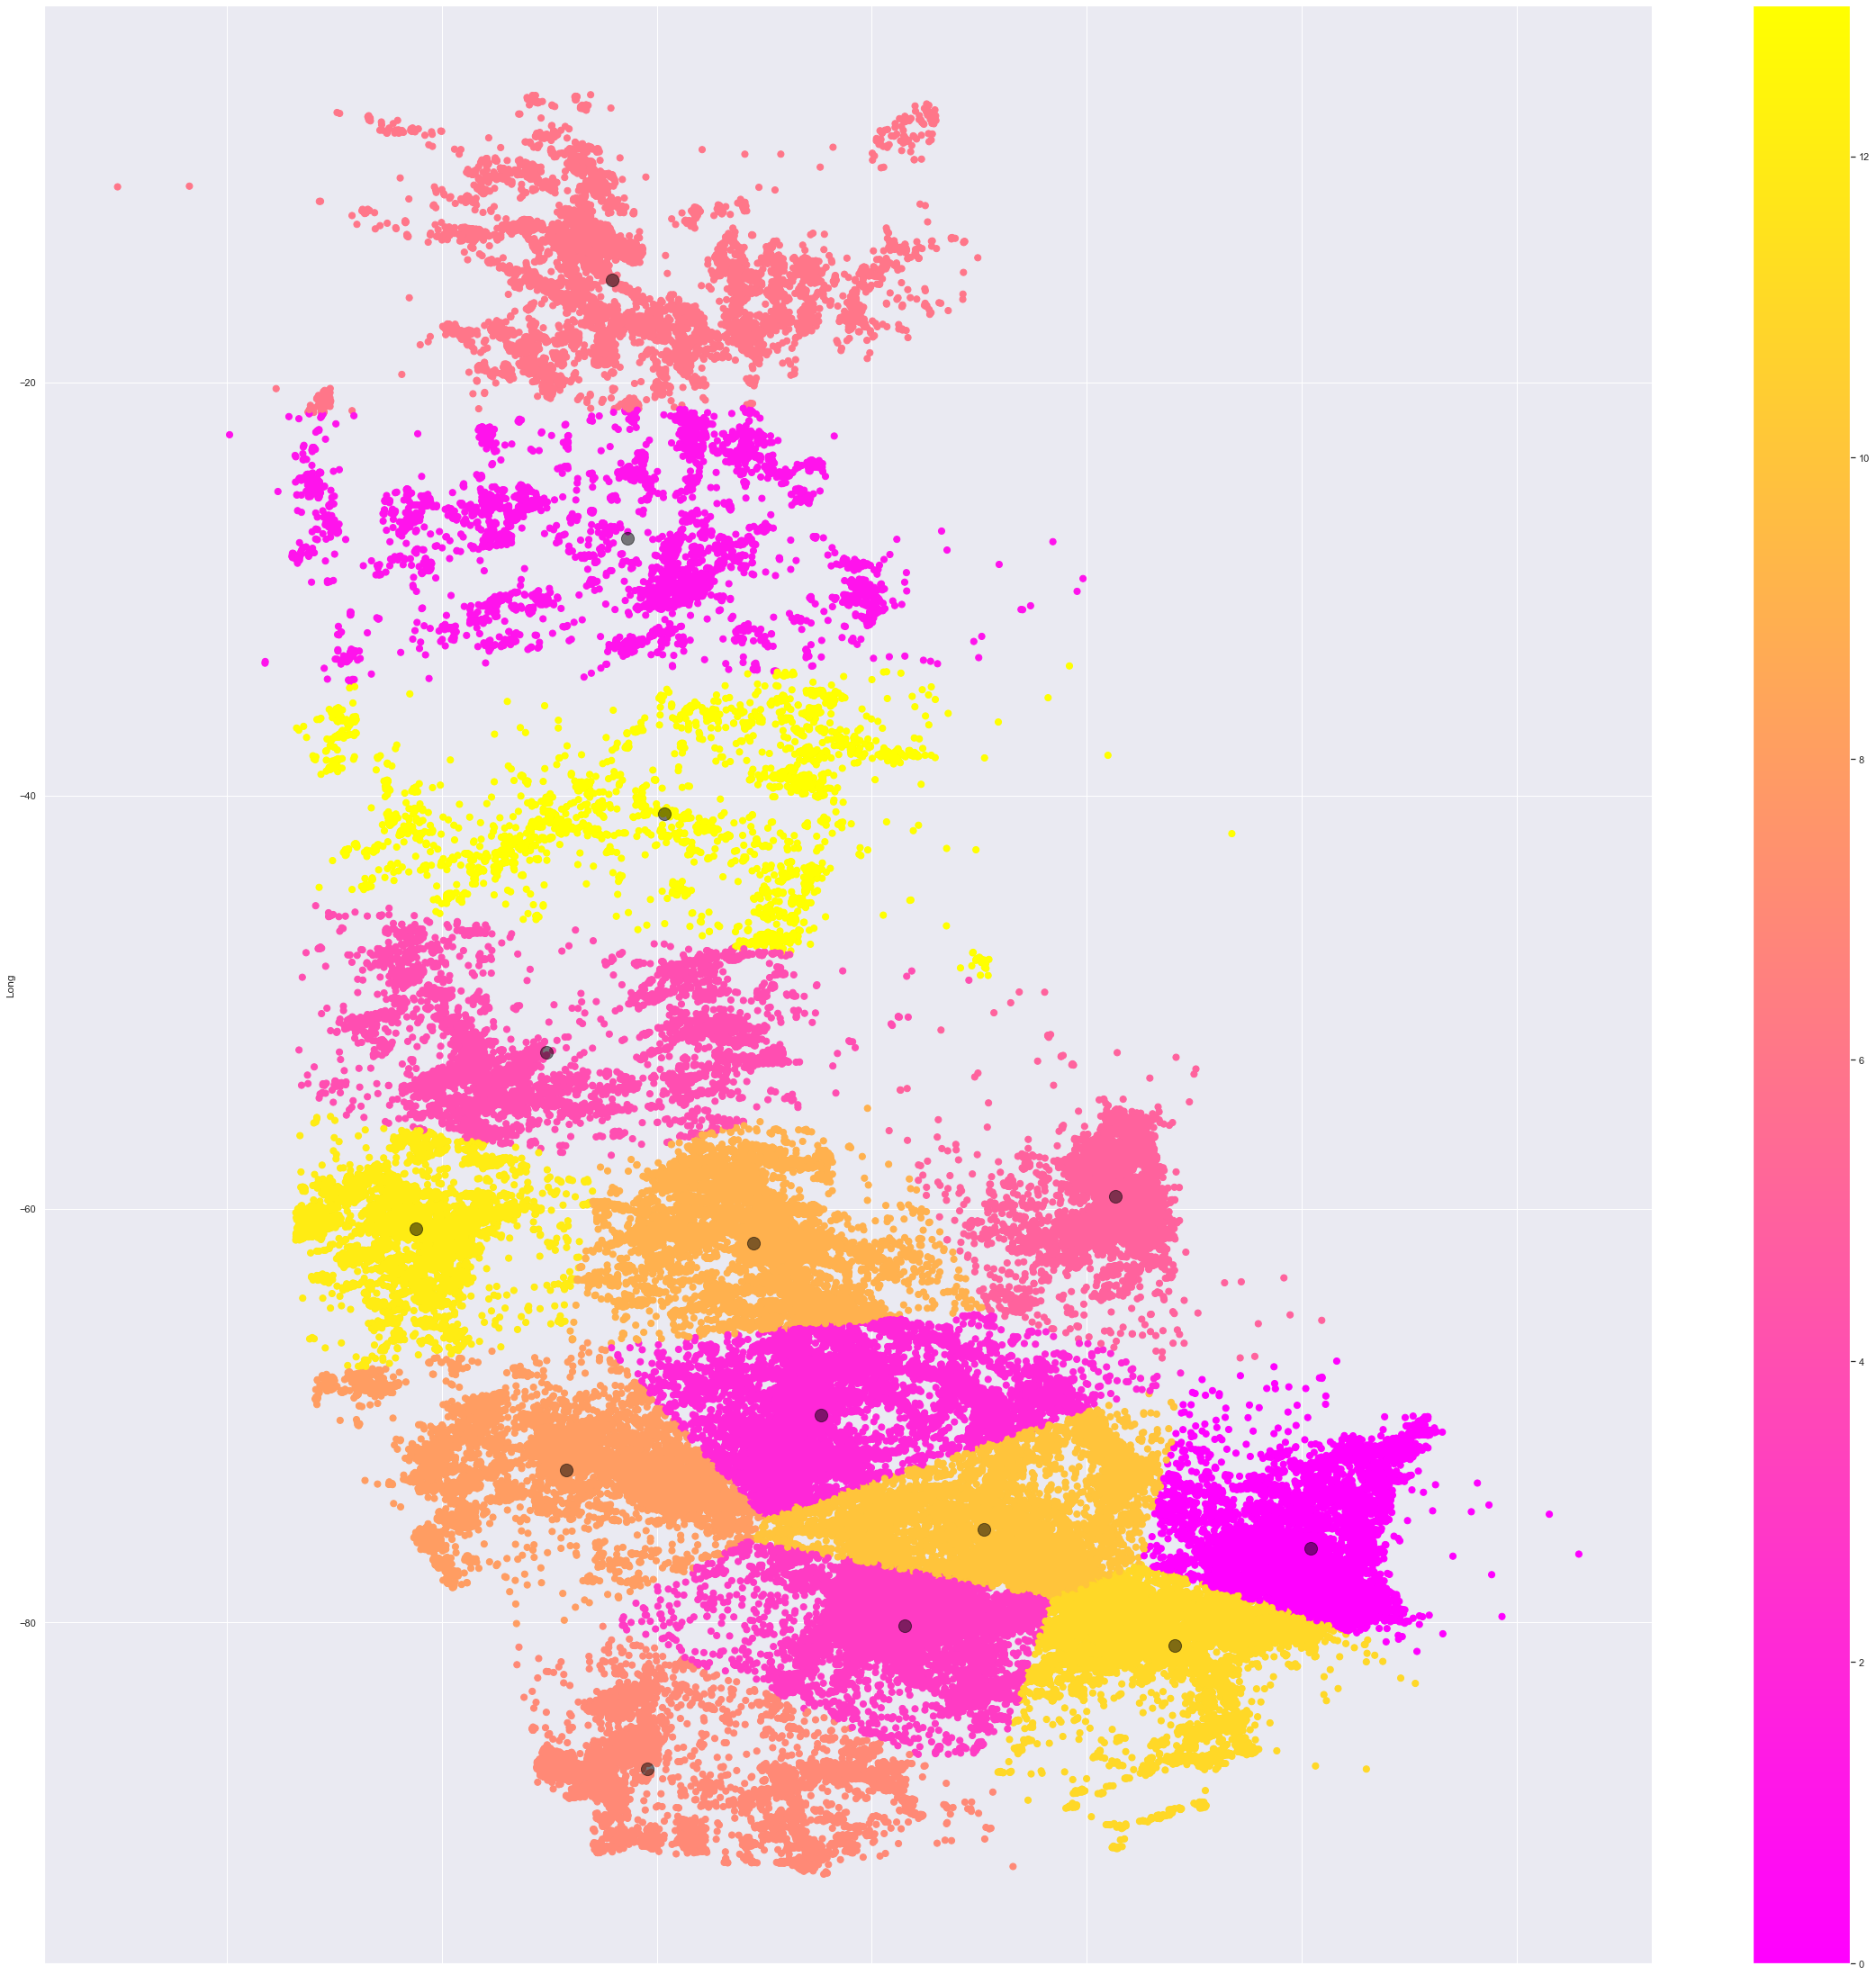

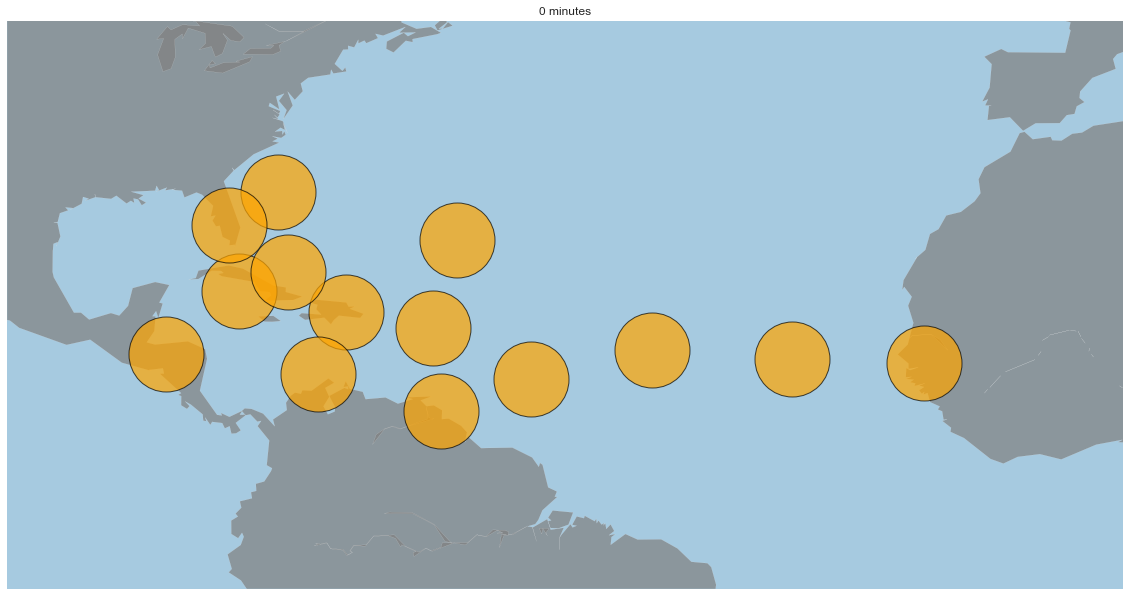

In [8]:
kmeansify(df, 14)

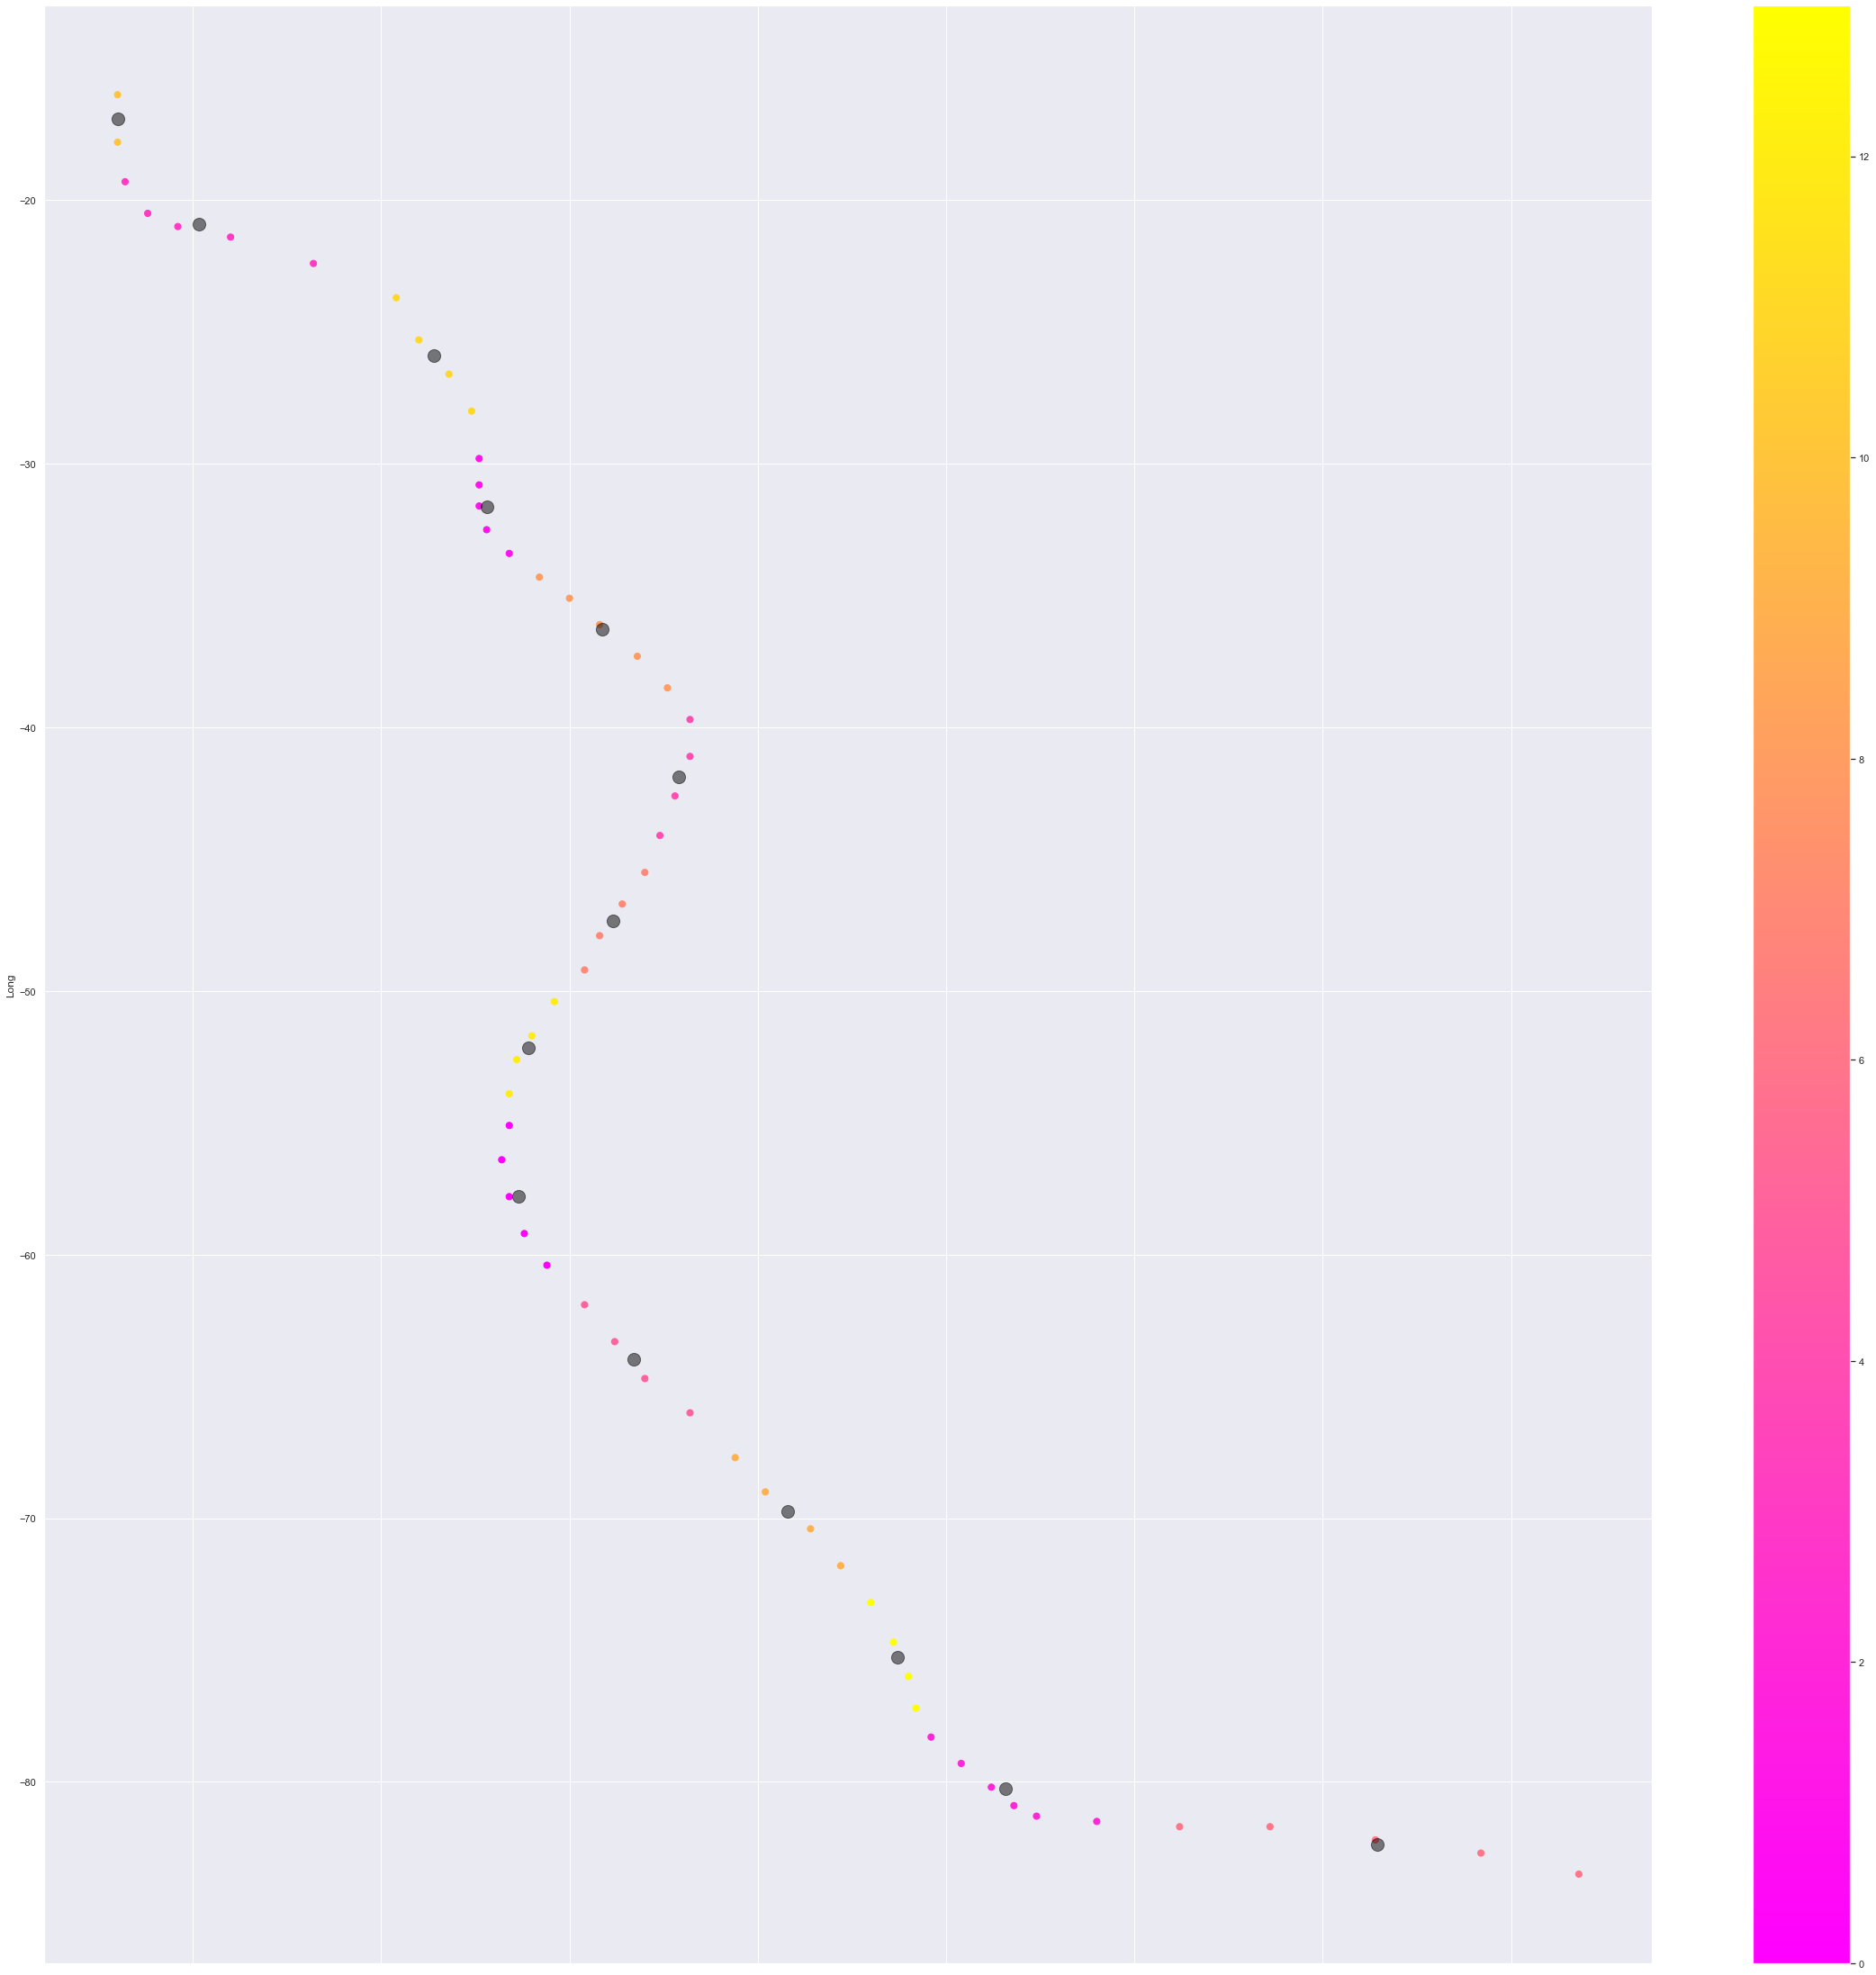

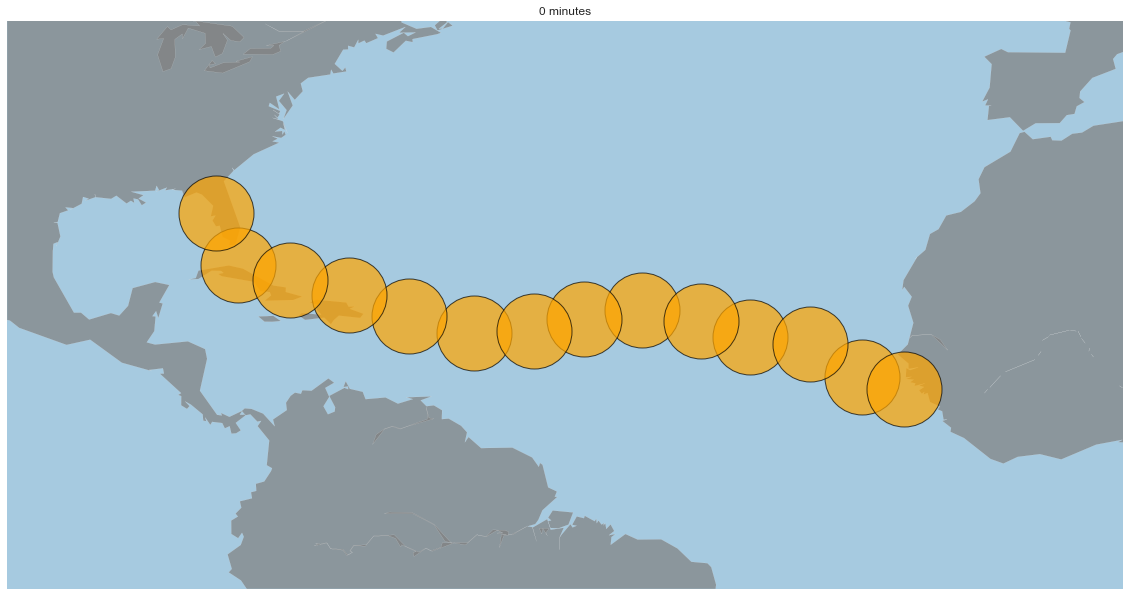

In [9]:
kmeansify(df_center, 14)

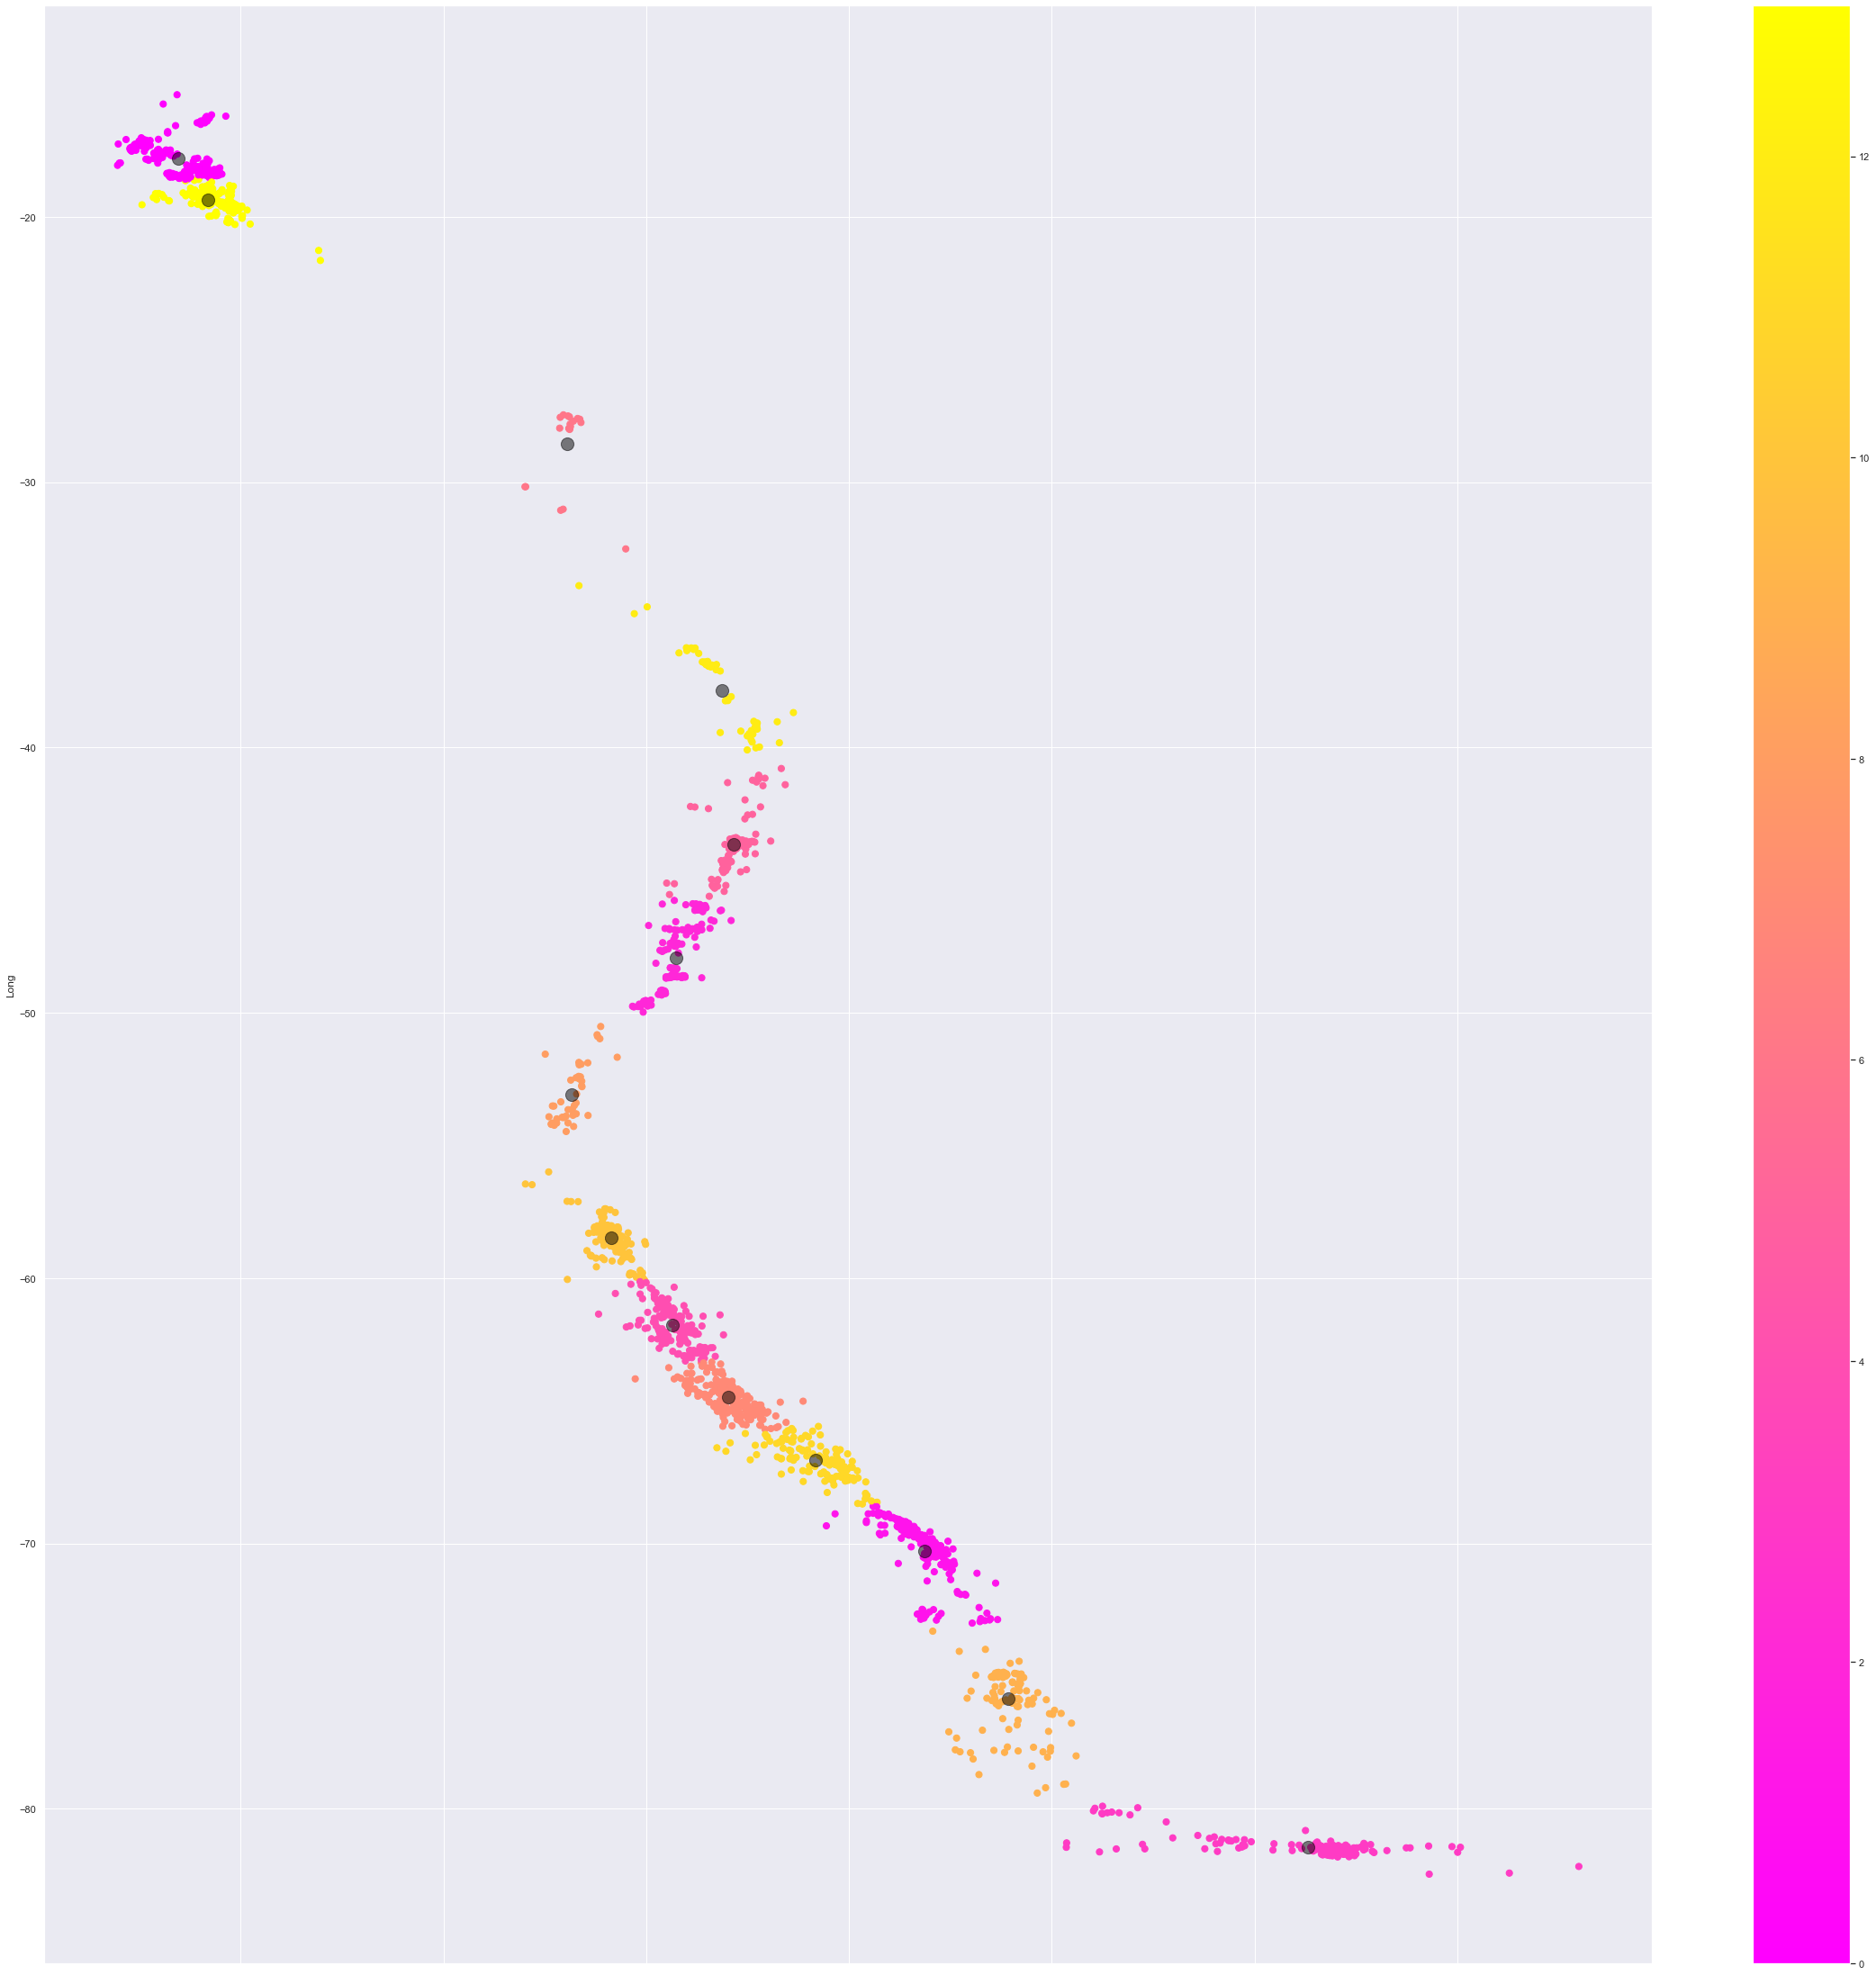

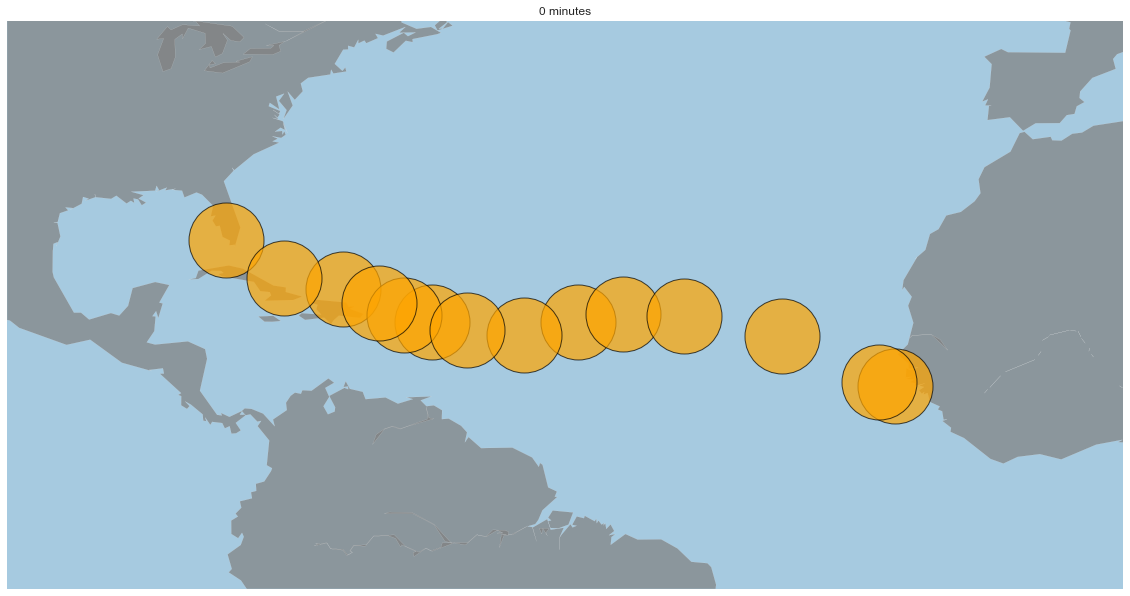

In [10]:
kmeansify(df_inner, 14)

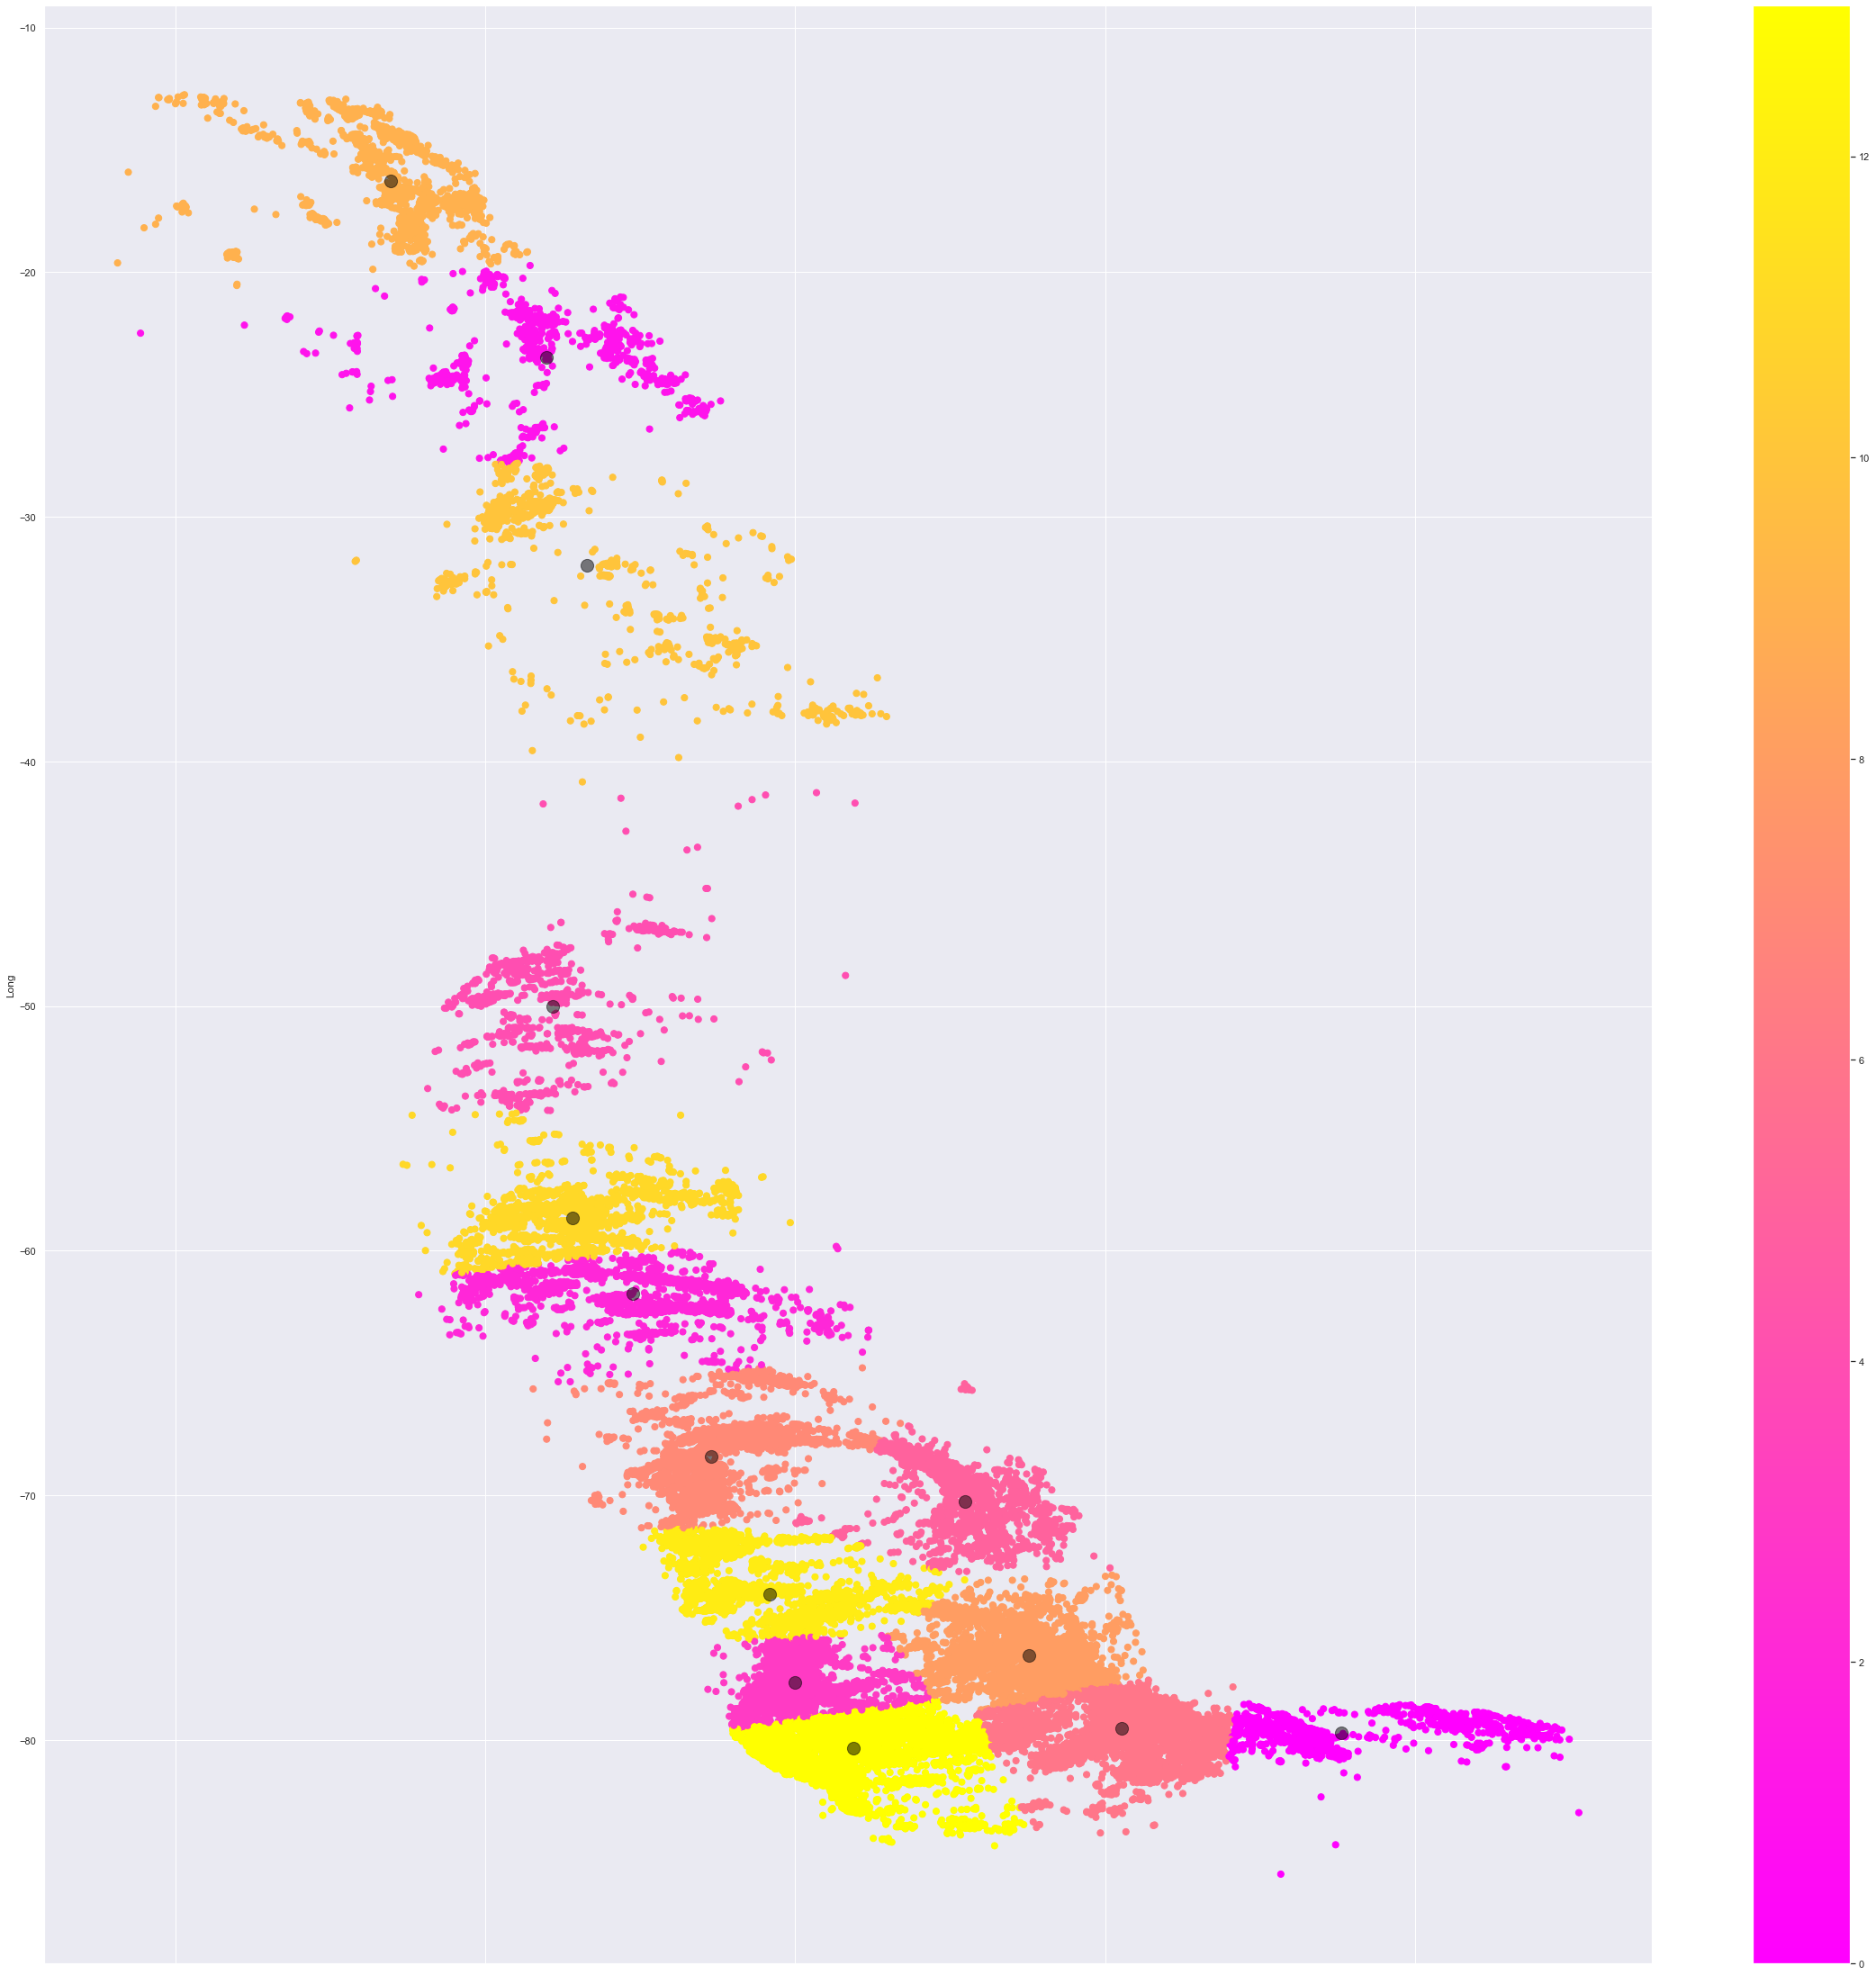

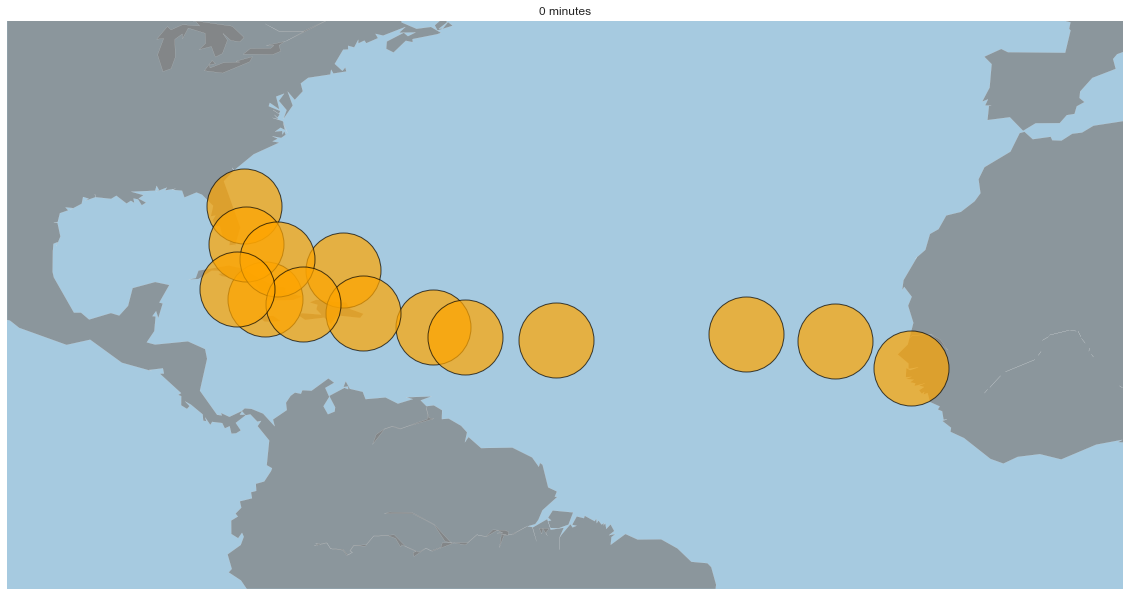

In [11]:
kmeansify(df_rainband, 14)

In [12]:
#DEPRECATED
'''#elbow graph for visual estimation of ideal cluster count
clusters = range(1,16)

kmeans = [KMeans(n_clusters=i) for i in clusters]

y = df[['Lat']]
x = df[['Long']]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

plt.plot(clusters, score)

plt.show()'''

'''#kmeans using the set cluster count
kmeans = KMeans(n_clusters=4, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()'''

'''for n_clusters in range(1,16):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
        kmeans.fit(cluster_df)
        inertia = kmeans.inertia_
        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)
        '''

'for n_clusters in range(1,16):\n        kmeans = KMeans(n_clusters=n_clusters, init=\'k-means++\')\n        kmeans.fit(cluster_df)\n        inertia = kmeans.inertia_\n        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)\n        '